In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import plotly
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder 
from sklearn import metrics
from sklearn import cluster
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [71]:
# First, install the yfinance package
!pip install yfinance


Defaulting to user installation because normal site-packages is not writeable


In [72]:
# After restarting the kernel, import and use yfinance
import yfinance as yf

data = yf.download(['KO', 'PEP'], start="2018-01-01", end="2023-01-01")['Close']
data.head()





[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Date,,
2018-01-02,36.272217,95.272125
2018-01-03,36.192570,95.021973
2018-01-04,36.702320,95.490005
2018-01-05,36.694359,95.764389
2018-01-08,36.638599,95.215645


In [75]:
# Perform OLS regression i.e Ordinary Least Squares Analysis (KO as dependent variable, PEP as independent variable)
model = sm.OLS(data['KO'], sm.add_constant(data['PEP'])).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     KO   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 1.309e+04
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        15:29:11   Log-Likelihood:                -2750.9
No. Observations:                1259   AIC:                             5506.
Df Residuals:                    1257   BIC:                             5516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5345      0.311     33.853      0.0

C:\Users\Karan\AppData\Local\Temp\ipykernel_14284\4226267818.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = data['KO'] - (model.params[1] * data['PEP'] + model.params[0])


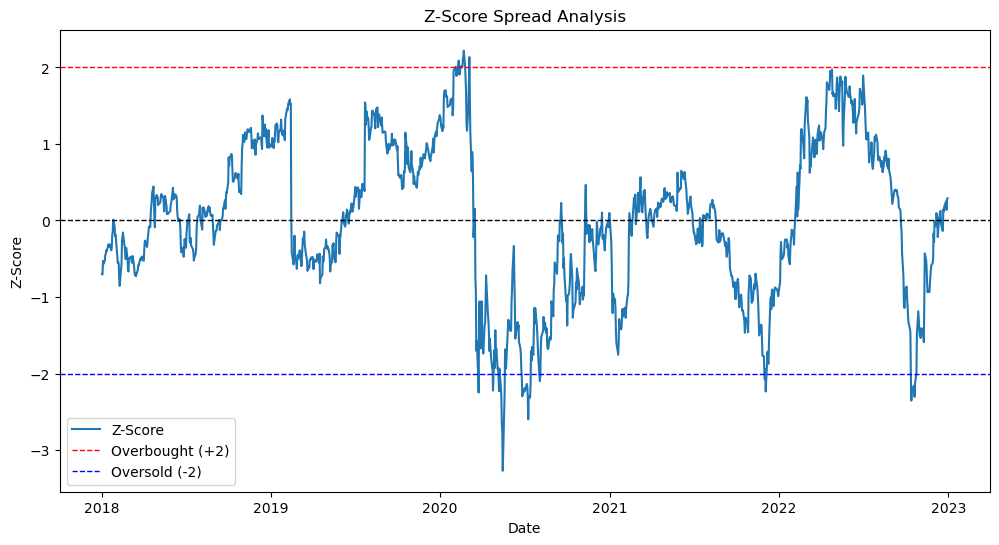

Recent Z-Score: 0.29014579745450453
The spread is within a normal range (-2 < Z < 2). No trading signal.


C:\Users\Karan\AppData\Local\Temp\ipykernel_14284\4226267818.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Recent Z-Score:", z_score[-1])
C:\Users\Karan\AppData\Local\Temp\ipykernel_14284\4226267818.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z_score[-1] > 2:
C:\Users\Karan\AppData\Local\Temp\ipykernel_14284\4226267818.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z_score[-1] < -2:


In [79]:
# Calculate the spread
spread = data['KO'] - (model.params[1] * data['PEP'] + model.params[0])

# Calculate Z-score of the spread
mean_spread = spread.mean()
std_spread = spread.std()
z_score = (spread - mean_spread) / std_spread

# Plot the Z-score
plt.figure(figsize=(12, 6))
plt.plot(z_score, label='Z-Score')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(2, color='red', linestyle='--', linewidth=1, label='Overbought (+2)')
plt.axhline(-2, color='blue', linestyle='--', linewidth=1, label='Oversold (-2)')
plt.title('Z-Score Spread Analysis')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

# Interpretation of Z-Score
print("Recent Z-Score:", z_score[-1])
if z_score[-1] > 2:
    print("The spread is overbought (Z > 2). Consider shorting the spread.")
elif z_score[-1] < -2:
    print("The spread is oversold (Z < -2). Consider buying the spread.")
else:
    print("The spread is within a normal range (-2 < Z < 2). No trading signal.")


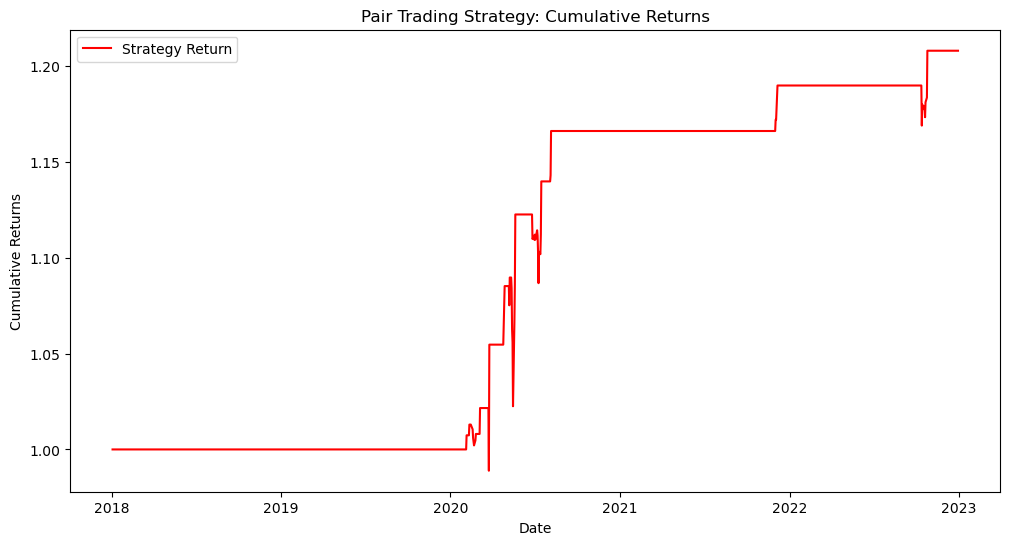

In [85]:
# Step 4: Backtesting logic
# Define trading signals based on Z-score thresholds
data['Spread'] = spread
data['Z-Score'] = z_score
data['Signal'] = 0  # No position initially
data.loc[z_score > 2, 'Signal'] = -1  # Short spread (sell KO, buy PEP)
data.loc[z_score < -2, 'Signal'] = 1  # Long spread (buy KO, sell PEP)

# Shift signal to avoid lookahead bias
data['Signal'] = data['Signal'].shift(1)

# Calculate strategy returns
data['KO_Return'] = data['KO'].pct_change()
data['PEP_Return'] = data['PEP'].pct_change()
data['Strategy_Return'] = data['Signal'] * (data['KO_Return'] - data['PEP_Return'])

# Calculate cumulative returns
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

# Step 5: Plot results
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Return'], label='Strategy Return', color='red')
plt.title('Pair Trading Strategy: Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



In [83]:
# Step 6: Performance metrics
total_return = data['Cumulative_Strategy_Return'].iloc[-1] - 1
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)  # Annualized Sharpe ratio
max_drawdown = (data['Cumulative_Strategy_Return'] / data['Cumulative_Strategy_Return'].cummax() - 1).min()

print("\nPerformance Metrics:")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")


Performance Metrics:
Total Return: 20.80%
Sharpe Ratio: 0.73
Max Drawdown: -6.16%
